# Worksheet 17

Name: Kian Boon Tan

UID: U93983891 

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

This scenario is similar to the movie example in class, but we now have "like"s and "dislike"s instead of a 1-5 rating. We can simply encode the "like"s and "dislike"s as 1 and 2 respectively, and build a similar recommender system with the reduced rating domain. We can continue to use neighborhood methods as we still have access to data for movies, users, and their ratings.

b) Describe 3 challenges of building a recommender system

1. If using neighborhood methods, it is difficult to account for biases in the data (e.g. users rate movies differently based on their moods, tastes change over time etc.)
2. If we are using feature extraction, it is difficult to decide on which features we want to categorize our objects by. For example, when categorizing movies, are their genres important, or their runtime?
3. Continuing with feature extraction, even after we know our features, it is also difficult to categorize objects into their correct categories. For instance, categorizing a movie as "funny" loses a lot of subjectivity. Are they child-friendly jokes? Or does the movie rely on dark humor extensively?

c) Why is SVD not an option for collaborative filtering?

The data matrix $R$ we are given is typically sparse (for instance, users are unlikely to have watched all movies). Instead, we can formulate an optimization problem and use the Expectation-Maximization algorithm approach.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE =  1.4322006136814758


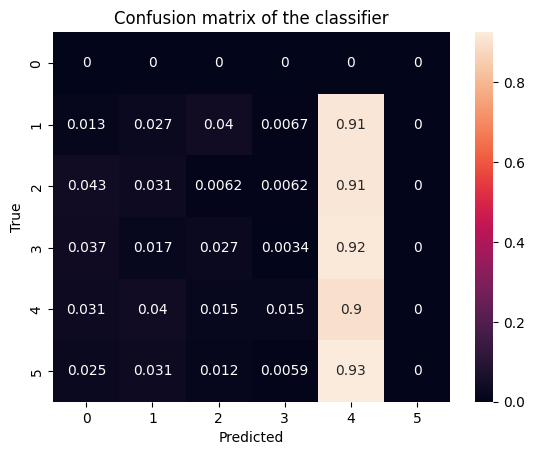

In [12]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
param_grid = ParamGridBuilder().addGrid(
        als.rank, [10, 50]).addGrid(
        als.regParam, [.1]).addGrid(
        als.maxIter, [10]).build()
evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Score", 
        predictionCol="prediction")

# Trying out CrossValidator.
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

# rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it

rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()

# X_test_processed['Score'] = rec['prediction'].values.reshape(-1, 1)
# print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

# Fill in missing scores.
X_test_processed = X_test_processed.merge(rec, on=['UserId_fact', 'ProductId_fact'], how='left')
average_score = init_df['Score'].mean()
X_test_processed['prediction'] = X_test_processed['prediction'].fillna(average_score)

print("Kaggle RMSE = ", mean_squared_error(Y_test, X_test_processed['prediction'], squared=False))

# cm = confusion_matrix(Y_test, X_test_processed['Score'], normalize='true')
cm = confusion_matrix(Y_test, X_test_processed['prediction'].astype(int), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()